# Full covariance Gaussian approximation

This reading follows on from the previous coding tutorial, and shows how to set up a full covariance variational approximating Gaussian distribution.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)

# Additional packages for this reading
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

TF version: 2.3.0
TFP version: 0.11.1


In the previous tutorial, you approximated a full covariance Gaussian with a diagonal covariance Gaussian. This reading notebook is a supplement that shows how you can configure a full covariance Gaussian as the approximating distribution.

The code below initializes the same target distribution that you saw in the tutorial.

In [2]:
# Define the target distribution

tf.random.set_seed(41)

p_mu = [0., 0.]
p_Sigma = tfp.bijectors.Chain([tfb.TransformDiagonal(tfb.Softplus()),
                               tfb.FillTriangular()])(tf.random.uniform([3]))
p = tfd.MultivariateNormalTriL(loc=p_mu, scale_tril=p_Sigma)

To create a trainable normal distribution with full covariance matrix, we use the `MultivariateNormalTriL` Distribution.

In [3]:
# Define the approximating distribution

scale_tril_init = tfb.FillScaleTriL()(tf.random.normal([3]))
q = tfd.MultivariateNormalTriL(loc=tf.Variable(tf.random.normal([2])),
                               scale_tril=tfp.util.TransformedVariable(scale_tril_init,
                                                                       bijector=tfb.FillScaleTriL()))

As with `MultivariateNormalDiag`, `loc` is specified as a randomly intialized `tf.Variable`.

The lower-triangular matrix `scale_tril`, on the other hand, is initialized as
```
    tfp.util.TransformedVariable(scale_tril_init,
                                 bijector=tfb.FillScaleTriL())
```
Let's unpack this bit by bit. `tfp.util.TransformedVariable` is a class that allows us to initialize a Variable using a value for its bijection. Parameter updates take place on the unconstrained Variable, while the bijection enforces a constraint (e.g. positivity, shape, etc.).

In this case, we initialize `scale_tril` using a lower-triangular matrix, `scale_tril_init`.

The bijector handed to `TransformedVariable` is `tfb.FillScaleTriL`. This bijector is equivalent to a `tfb.Chain` of `tfb.FillTriangular` followed by `tfb.TransformDiagonal`.

`tfb.FillTriangular` inserts the elements of a vector into a lower-triangular matrix in a clockwise spiral. `tfb.TransformDiagonal` then applies a bijection to the diagonal of this matrix. 

The diagonal bijection applied by `tfb.FillScaleTriL` can be specified via the `diag_bijector` argument. By default, it is a bijector chain of `tfb.Softplus` followed by addition of `1e-5`.

If you refer back to how `p_Sigma` is declared in the code cell above, you can see that it is initialized using a bijector chain that is similar to `tfb.FillScaleTriL`'s.

#### Fit the approximating distribution by minimising KL divergence

The target and trainable distributions have been initialized. All that remains is to fit the trainable distribution to the target. 

The code below is identical to what you saw for fitting the diagonal covariance example in the coding tutorial.

In [4]:
@tf.function
def loss_and_grads(dist_a, dist_b):
    '''
        Returns D_{KL}[dist_a || dist_b] and the gradients of this 
        with respect to the trainable Variables of dist_a.
    '''
    with tf.GradientTape() as tape:
        loss = tfd.kl_divergence(dist_a, dist_b)
    return loss, tape.gradient(loss, dist_a.trainable_variables)

In [5]:
# Define function for graphics

def plot_density_contours(density, X1, X2, contour_kwargs, ax=None):
    '''
        Plots the contours of a bivariate TensorFlow density function (i.e. .prob()).
        X1 and X2 are numpy arrays of mesh coordinates.
    '''
    X = np.hstack([X1.flatten()[:, np.newaxis], X2.flatten()[:, np.newaxis]])
    density_values = np.reshape(density(X).numpy(), newshape=X1.shape)
    
    if ax==None:
        _, ax = plt.subplots(figsize=(7, 7))
    
    ax.contour(X1, X2, density_values, **contour_kwargs)
    return(ax)

x1 = np.linspace(-5, 5, 1000)
x2 = np.linspace(-5, 5, 1000)
X1, X2 = np.meshgrid(x1, x2)
contour_levels = np.linspace(1e-4, 10**(-0.8), 20)

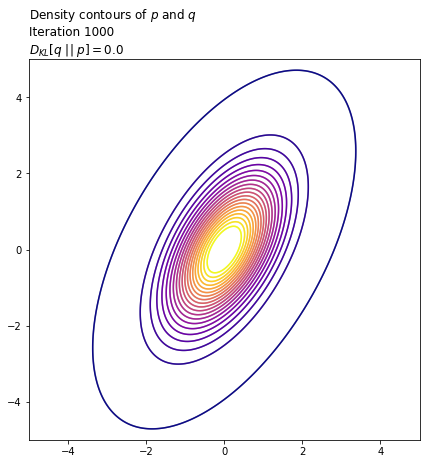

In [6]:
# Set up and run a custom training loop to minimise the KL loss

num_train_steps = 1000
opt = tf.keras.optimizers.Adam(learning_rate=.01)
for i in range(num_train_steps):
    
    # Compute the KL divergence and its gradients
    q_loss, grads = loss_and_grads(q, p)
    
    # Update the trainable variables using the gradients via the optimizer
    opt.apply_gradients(zip(grads, q.trainable_variables))
    
    # Plot the updated density 
    if ((i + 1) % 10 == 0):
        clear_output(wait=True)
        ax = plot_density_contours(p.prob, X1, X2,
                                   {'levels':contour_levels,
                                    'cmap':'cividis', 'alpha':0.5})
        ax = plot_density_contours(q.prob, X1, X2, 
                                   {'levels':contour_levels,
                                    'cmap':'plasma'}, ax=ax)
        ax.set_title('Density contours of $p$ and $q$\n' +
                     'Iteration ' + str(i + 1) + '\n' +
                      '$D_{KL}[q \ || \ p] = ' + 
                      str(np.round(q_loss.numpy(), 4)) + '$',
                      loc='left')
        plt.pause(.01)

As you can see, using a trainable distribution that is in the same parametric family as the target enables the KL divergence to be minimised to zero, indicating that the target distribution has been learnt perfectly.

### Summary

This notebook showed how you can initialize and train a normal distribution with full covariance matrix. `MultivariateNormalTriL` with a Variable transformed via `FillScaleTriL` should be your go-to for learnt full covariance matrices.